In [25]:
!pip install d2l==0.17.2

  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


We will work with the Fashion-MNIST dataset, just introduced in Section 3.5, setting up a data iterator with batch size 256.

In [26]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

##3.6.1. Initializing Model Parameters
Each example in the raw dataset is a  28×28  image. In this section, we will flatten each image, treating them as vectors of length 784.

**Because our dataset has 10 classes,
our network will have an output dimension of 10.**
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.
As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.

In [27]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

##3.6.2. Defining the Softmax Operation


In [28]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

We are now ready to (**implement the softmax operation**).
Recall that softmax consists of three steps:
(i) we exponentiate each term (using `exp`);
(ii) we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;
(iii) we divide each row by its normalization constant,
ensuring that the result sums to 1.
Before looking at the code, let us recall
how this looks expressed as an equation:

$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$

In [29]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input, we turn each element into a non-negative number. Moreover, each row sums up to 1, as is required for a probability.

In [30]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.13202967, 0.47616982, 0.10067745, 0.04675312, 0.2443699 ],
        [0.29209962, 0.20467772, 0.18573883, 0.18303429, 0.13444953]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9999999, 1.       ], dtype=float32)>)

##3.6.3. Defining the Model
Now that we have defined the softmax operation, we can implement the softmax regression model. The below code defines how the input is mapped to the output through the network. Note that we flatten each original image in the batch into a vector using the reshape function before passing the data through our model.

In [31]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

##3.6.4. Defining the Loss Function

Implement the cross-entropy loss function.

Below, we create sample data y_hat with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. With y we know that in the first example the first class is the correct prediction and in the second example the third class is the ground-truth. Using y as the indices of the probabilities in y_hat, we pick the probability of the first class in the first example and the probability of the third class in the second example.

In [32]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [33]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

##3.6.5. Classification Accuracy

To compute accuracy we do the following. First, if y_hat is a matrix, we assume that the second dimension stores prediction scores for each class. We use argmax to obtain the predicted class by the index for the largest entry in each row. Then we compare the predicted class with the ground-truth y elementwise. Since the equality operator == is sensitive to data types, we convert y_hat’s data type to match that of y. The result is a tensor containing entries of 0 (false) and 1 (true). Taking the sum yields the number of correct predictions.

In [34]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

We will continue to use the variables y_hat and y defined before as the predicted probability distributions and labels, respectively. We can see that the first example’s prediction class is 2 (the largest element of the row is 0.6 with the index 2), which is inconsistent with the actual label, 0. The second example’s prediction class is 2 (the largest element of the row is 0.5 with the index of 2), which is consistent with the actual label, 2. Therefore, the classification accuracy rate for these two examples is 0.5.

In [35]:
accuracy(y_hat, y) / len(y)

0.5

We can evaluate the accuracy for any model net on a dataset that is accessed via the data iterator data_iter.

In [36]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

Here Accumulator is a utility class to accumulate sums over multiple variables.  In the above evaluate_accuracy function, we create 2 variables in the Accumulator instance for storing both the number of correct predictions and the number of predictions, respectively. Both will be accumulated over time as we iterate over the dataset.

In [37]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

Because we initialized the net model with random weights, the accuracy of this model should be close to random guessing, i.e., 0.1 for 10 classes.

In [38]:
evaluate_accuracy(net, test_iter)

0.0946

##3.6.6. Training
Training loop for softmax regression.First, we define a function to train for one epoch. Note that updater is a general function to update the model parameters, which accepts the batch size as an argument.


In [39]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function, we define a utility class that plot data in animation. Again, it aims to simplify code.

In [40]:
class Animator: 
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The following training function then trains a model net on a training dataset accessed via train_iter for multiple epochs, which is specified by num_epochs. At the end of each epoch, the model is evaluated on a testing dataset accessed via test_iter. We will leverage the Animator class to visualize the training progress.

In [41]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

we use the minibatch stochastic gradient descent to optimize the loss function of the model with a learning rate 0.1.

In [42]:
class Updater():
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

Now we train the model with 10 epochs. Note that both the number of epochs (num_epochs), and learning rate (lr) are adjustable hyperparameters. By changing their values, we may be able to increase the classification accuracy of the model.

In [43]:
pip install matplotlib==3.0.2

  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.2 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


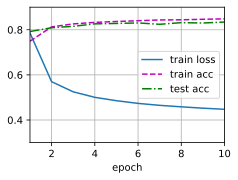

In [44]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

##3.6.7. Prediction
Now that training is complete, our model is ready to classify some images. Given a series of images, we will compare their actual labels (first line of text output) and the predictions from the model (second line of text output).

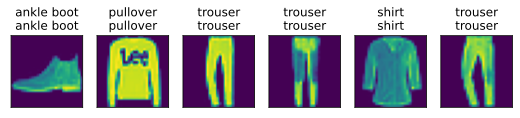

In [46]:
def predict_ch3(net, test_iter, n=6): 
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

Output of cell [44]:

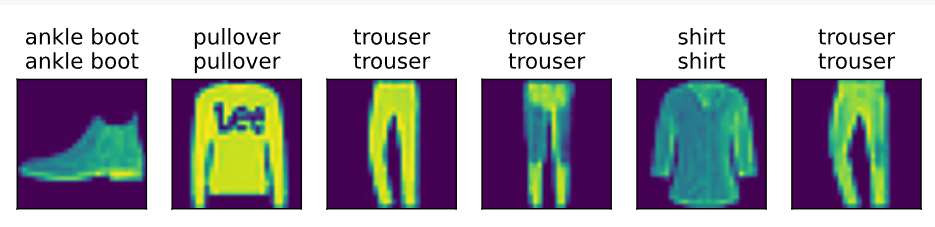